# Lab 14, 3.08 - Making predictions with logistic regression

In this lab, you will be using the Sakila database of movie rentals.

In order to optimize our inventory, we would like to know which films will be rented next month and we are asked to create a model to predict it.

# Instructions

1 - Create a query or queries to extract the information you think may be relevant for building the prediction model. It should include some film features and some rental features.

2 - Read the data into a Pandas dataframe.

3 - Analyze extracted features and transform them. You may need to encode some categorical variables, or scale numerical variables.

4 - Create a query to get the list of films and a boolean indicating if it was rented last month. This would be our target variable.

5 - Create a logistic regression model to predict this variable from the cleaned data.

6 - Evaluate the results.


# setup

In [39]:
from sqlalchemy import create_engine
import getpass
import pandas as pd
import pymysql
import seaborn as sns
import sqlalchemy

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from scipy.stats import normaltest
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import cohen_kappa_score
from sklearn.preprocessing import Normalizer, StandardScaler
from sklearn.metrics import classification_report
from collections import Counter

import getpass  # To get the password without showing the input
password = getpass.getpass()

········


In [13]:
connection_string = 'mysql+pymysql://root:' + password + '@localhost/bank'
engine = create_engine(connection_string)
engine.execute("USE sakila")


In [10]:
# query 1 > first modelling resulted in accuracy of 1.0 - this can't be right. Revisit the model with query #2...
query = """select r.film_id, cf.category_name, rating, fl.length, ic.inventory_count, rm.rented_in_may, rm.rental_count_may, rj.rented_in_june, rj.rental_count_june 
from rating as r
join film_length  as fl on r.film_id = fl.film_id
join inventory_counts as ic on fl.film_id = ic.film_id
join category_of_films as cf on ic.film_id = cf.film_id
join rentals_may_2 as rm on cf.film_id = rm.film_id 
join rentals_june_2 as rj on  rm.film_id = rj.film_id
order by r.film_id"""

data = pd.read_sql_query(query, engine)
data.head()

ProgrammingError: (pymysql.err.ProgrammingError) (1064, "You have an error in your SQL syntax; check the manual that corresponds to your MySQL server version for the right syntax to use near 'select r.film_id, cf.category_name, rating, fl.length, ic.inventory_count, rm.re' at line 1")
[SQL: use sakila select r.film_id, cf.category_name, rating, fl.length, ic.inventory_count, rm.rented_in_may, rm.rental_count_may, rj.rented_in_june, rj.rental_count_june 
from rating as r
join film_length  as fl on r.film_id = fl.film_id
join inventory_counts as ic on fl.film_id = ic.film_id
join category_of_films as cf on ic.film_id = cf.film_id
join rentals_may_2 as rm on cf.film_id = rm.film_id 
join rentals_june_2 as rj on  rm.film_id = rj.film_id
order by r.film_id]
(Background on this error at: http://sqlalche.me/e/13/f405)

In [14]:
# query 2 - added popoular actors (who have starred in more than 30 films)
query = """select r.film_id, cf.category_name, count_popular_actors, rating, fl.length, ic.inventory_count, rm.rented_in_may, rm.rental_count_may, rj.rented_in_june, rj.rental_count_june 
from rating as r
join film_length  as fl on r.film_id = fl.film_id
join inventory_counts as ic on fl.film_id = ic.film_id
join category_of_films as cf on ic.film_id = cf.film_id
join film_count_pop_actors as fa ON cf.film_id = fa.film_id 
join rentals_may_2 as rm on cf.film_id = rm.film_id 
join rentals_june_2 as rj on  rm.film_id = rj.film_id
order by r.film_id;"""

data = pd.read_sql_query(query, engine)
data.head()

,film_id,category_name,count_popular_actors,rating,length,inventory_count,rented_in_may,rental_count_may,rented_in_june,rental_count_june
0,1,Documentary,16.0,PG,86,8,y,2,y,3
1,2,Horror,6.0,G,48,3,n,0,n,0
2,3,Documentary,4.0,NC-17,50,4,n,0,y,1
3,4,Horror,14.0,G,117,7,y,1,y,2
4,5,Family,3.0,G,130,3,y,1,y,2


# data explore and check for nulls

In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 955 entries, 0 to 954
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   film_id               955 non-null    int64  
 1   category_name         955 non-null    object 
 2   count_popular_actors  955 non-null    float64
 3   rating                955 non-null    object 
 4   length                955 non-null    int64  
 5   inventory_count       955 non-null    int64  
 6   rented_in_may         955 non-null    object 
 7   rental_count_may      955 non-null    int64  
 8   rented_in_june        955 non-null    object 
 9   rental_count_june     955 non-null    int64  
dtypes: float64(1), int64(5), object(4)
memory usage: 74.7+ KB


In [16]:
data['rented_in_may'].value_counts()

y    625
n    330
Name: rented_in_may, dtype: int64

In [17]:
data['rented_in_june'].value_counts()

y    897
n     58
Name: rented_in_june, dtype: int64

In [18]:
data['rating'].value_counts()

PG-13    213
NC-17    202
R        187
PG       183
G        170
Name: rating, dtype: int64

In [19]:
data['category_name'].value_counts()

Sports         72
Family         67
Foreign        67
Animation      64
Documentary    63
Action         61
New            60
Drama          60
Sci-Fi         59
Children       58
Games          58
Comedy         56
Classics       54
Horror         53
Travel         52
Music          51
Name: category_name, dtype: int64

In [20]:
# Check numerical data for outliers, need for scaling, etc
data.describe()

,film_id,count_popular_actors,length,inventory_count,rental_count_may,rental_count_june
count,955.000000,955.000000,955.000000,955.000000,955.000000,955.00000
mean,502.728796,9.102618,115.363351,4.783246,1.037696,2.41466
std,287.660572,7.640778,40.430401,1.817724,0.988743,1.38644
min,1.000000,0.000000,46.000000,2.000000,0.000000,0.00000
25%,255.500000,4.000000,80.000000,3.000000,0.000000,1.00000
50%,505.000000,7.000000,114.000000,5.000000,1.000000,2.00000
75%,751.500000,12.000000,149.500000,6.000000,2.000000,3.00000
max,1000.000000,56.000000,185.000000,8.000000,5.000000,7.00000


In [21]:
data.corr()


,film_id,count_popular_actors,length,inventory_count,rental_count_may,rental_count_june
film_id,1.000000,-0.014183,0.050654,-0.017154,-0.034430,0.001391
count_popular_actors,-0.014183,1.000000,-0.021861,0.470511,0.144203,0.275907
length,0.050654,-0.021861,1.000000,-0.037210,-0.005771,-0.017015
inventory_count,-0.017154,0.470511,-0.037210,1.000000,0.366154,0.613431
rental_count_may,-0.034430,0.144203,-0.005771,0.366154,1.000000,0.616369
rental_count_june,0.001391,0.275907,-0.017015,0.613431,0.616369,1.000000


In [22]:
# drop following columns from query 2
data.drop('rented_in_may', axis=1, inplace=True)

In [23]:
data.drop('rental_count_june', axis=1, inplace=True)
data.head()

,film_id,category_name,count_popular_actors,rating,length,inventory_count,rental_count_may,rented_in_june
0,1,Documentary,16.0,PG,86,8,2,y
1,2,Horror,6.0,G,48,3,0,n
2,3,Documentary,4.0,NC-17,50,4,0,y
3,4,Horror,14.0,G,117,7,1,y
4,5,Family,3.0,G,130,3,1,y


# split numerical and categorical columns

In [26]:
numcols = data.select_dtypes(np.number)
numcols.head()

,film_id,count_popular_actors,length,inventory_count,rental_count_may
0,1,16.0,86,8,2
1,2,6.0,48,3,0
2,3,4.0,50,4,0
3,4,14.0,117,7,1
4,5,3.0,130,3,1


The categorical columns are:  ['category_name', 'rating', 'rented_in_june']

Frequency analysis of column:  category_name

Frequency analysis of column:  rating

Frequency analysis of column:  rented_in_june



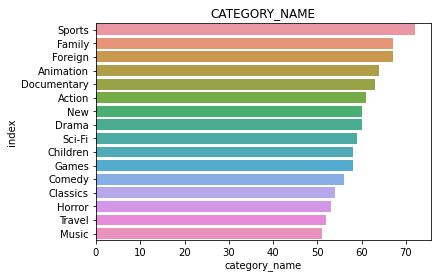

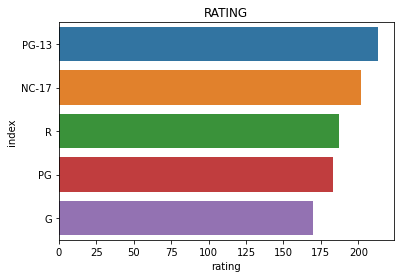

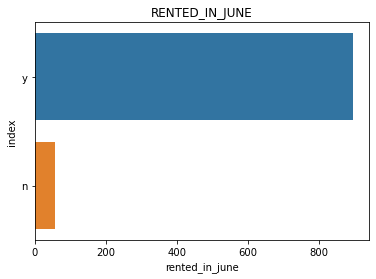

<Figure size 432x288 with 0 Axes>

In [27]:
cols_cat = list(data.select_dtypes(include=['object']).columns)

print("The categorical columns are: ",cols_cat)
print("========================================")
print()

for col in cols_cat:
    print("Frequency analysis of column: ",col)
    my_data = data[col].value_counts().reset_index()
    ax = sns.barplot(x=col, y="index", data = my_data).set_title(col.upper())
    plt.figure()
    print()

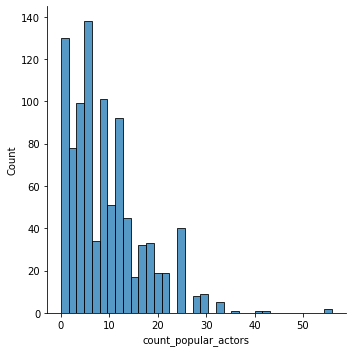

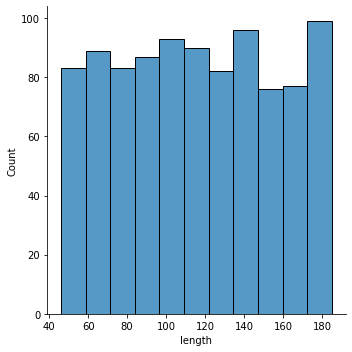

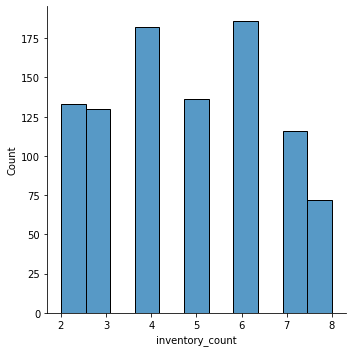

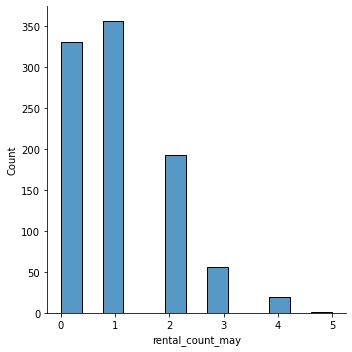

In [28]:
# distribution of numericals

sns.displot(data['count_popular_actors'])
plt.show()

sns.displot(data['length'])
plt.show()

sns.displot(data['inventory_count'])
plt.show()

sns.displot(data['rental_count_may'])
plt.show()


# setup model

In [40]:
#setup dummies for categorical columns

cat = data.select_dtypes(include = np.object)
cat = cat.drop(['rented_in_june'], axis=1)
objects_dummyfied = pd.get_dummies(cat)
display(objects_dummyfied.head())
display(objects_dummyfied.shape)



,category_name_Action,category_name_Animation,category_name_Children,category_name_Classics,category_name_Comedy,category_name_Documentary,category_name_Drama,category_name_Family,category_name_Foreign,category_name_Games,...,category_name_Music,category_name_New,category_name_Sci-Fi,category_name_Sports,category_name_Travel,rating_G,rating_NC-17,rating_PG,rating_PG-13,rating_R
0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0


(955, 21)

In [41]:
#concatenate numerical and categorical columns
X_independent = pd.concat([objects_dummyfied, numcols], axis = 1)

In [42]:
#x/y split
y_dependent = data['rented_in_june']


In [43]:
#train-test split
X_train, X_test, y_train, y_test = train_test_split(X_independent, y_dependent, test_size=0.3, random_state = 100)

# Modeling

In [44]:
classification = LogisticRegression(random_state=0, solver='lbfgs',  max_iter=500).fit(X_train, y_train)
y_pred = classification.predict(X_test)
print("The accuracy of the logistic_regression model is: %4.2f "% (classification.score(X_test, y_test)))

The accuracy of the logistic_regression model is: 0.94 


The accuracy of the model on test set is: 0.94 
[[  1  16]
 [  0 270]]


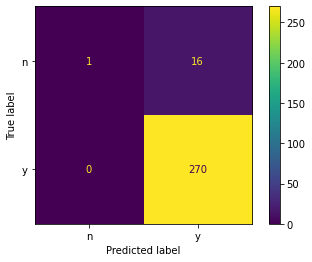

The Kappa of your model is: 0.11
              precision    recall  f1-score   support

         YES       0.00      0.00      0.00         0
          NO       0.00      0.00      0.00         0

   micro avg       0.00      0.00      0.00         0
   macro avg       0.00      0.00      0.00         0
weighted avg       0.00      0.00      0.00         0



/Users/jessieschloss/opt/anaconda3/envs/ironhack/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jessieschloss/opt/anaconda3/envs/ironhack/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jessieschloss/opt/anaconda3/envs/ironhack/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mod

In [45]:
print("The accuracy of the model on test set is: %4.2f " % accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
plot_confusion_matrix(classification, X_test, y_test) 
plt.show() 
print("The Kappa of your model is: %4.2f" % (cohen_kappa_score(y_test, y_pred)))
print(classification_report(y_test, y_pred, labels=['YES','NO']))

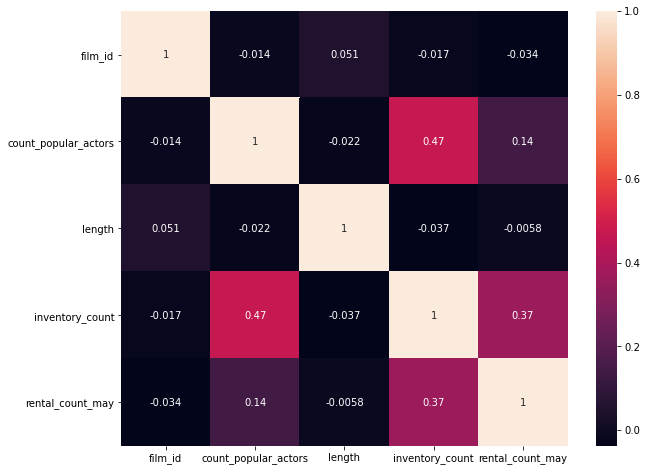

In [46]:
corr_matrix=data.corr(method='pearson')  # default
fig, ax = plt.subplots(figsize=(10, 8))
ax = sns.heatmap(corr_matrix, annot=True)
plt.show()